In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [34]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

In [35]:
X_validation=x_train[:int(0.2*len(x_train))].astype('float32')
Y_validation=y_train[:int(0.2*len(y_train))].astype('float32')
X_train=x_train[int(0.2*len(x_train)):].astype('float32')
Y_train=y_train[int(0.2*len(y_train)):].astype('float32')

In [36]:
assert len(X_train)==len(Y_train)==48000
assert len(X_validation)==len(Y_validation)==12000

In [37]:
print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set: {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set: {} samples".format(len(x_test)))


Image Shape: (28, 28)

Training Set: 48000 samples
Validation Set: 12000 samples
Test Set: 10000 samples


In [38]:
import numpy as np
X_train=np.pad(X_train,((0,0),(2,2),(2,2)),'constant')
X_validation=np.pad(X_validation,((0,0),(2,2),(2,2)),'constant')
X_test=np.pad(x_test,((0,0),(2,2),(2,2)),'constant')

X_train=X_train.reshape(48000,32,32,1)
X_validation=X_validation.reshape(12000,32,32,1)
X_test=X_test.reshape(10000,32,32,1)

print("Updated image shape: {} ".format(X_train[0].shape))

Updated image shape: (32, 32, 1) 


3.0


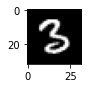

In [39]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(Y_train[index])

In [40]:
from sklearn.utils import shuffle
X_train,Y_train=shuffle(X_train,Y_train)

In [41]:
EPOCHS=10
BATCH_SIZE=128

In [42]:
X_train.shape

(48000, 32, 32, 1)

In [43]:


def LeNet(x):
    
    #Layer-1: Convolutional: 32*32*1-->28x28x6
    weights=tf.Variable(tf.truncated_normal((5,5,1,6)))
    bias=tf.Variable(tf.zeros((6)))
    convolution1=tf.nn.conv2d(x,weights,strides=[1,1,1,1],padding='VALID')
    conv1=tf.nn.bias_add(convolution1,bias)
    
    #activation
    conv1=tf.nn.relu(conv1)
    
    #Pooling:28x28x6-->14x14x6
    conv1_pooled=tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #Layer-2
    #Convolution:14x14x6-->10x10x16
    weights2=tf.Variable(tf.truncated_normal((5,5,6,16)))
    bias2=tf.Variable(tf.zeros(16))
    convolution2=tf.nn.conv2d(conv1_pooled,weights2,strides=[1,1,1,1],padding='VALID')
    convolution2=tf.nn.bias_add(convolution2,bias2)
    
    #Activation
    convolution2=tf.nn.relu(convolution2)
    
    #Pooling:10x10x16-->5x5x16
    convolution2_pooled=tf.nn.max_pool(convolution2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    #flatten
    flatten=tf.reshape(convolution2_pooled,(-1,400), name=None)
    
    #fully connected:400-->120
    weights3=tf.Variable(tf.truncated_normal((400,120)))
    bias3=tf.Variable(tf.zeros(120))
    fc1=tf.add(tf.matmul(flatten,weights3),bias3)
    
    #activation
    fc1act=tf.nn.relu(fc1)
    
    #fully connected:120-->84
    weights4=tf.Variable(tf.truncated_normal((120,84)))
    bias4=tf.Variable(tf.zeros(84))
    fc2=tf.add(tf.matmul(fc1act,weights4),bias4)
    
    #activation
    fc2act=tf.nn.relu(fc2)
    
    #fully connected: 84-->10
    weights5=tf.Variable(tf.truncated_normal((84,10)))
    bias5=tf.Variable(tf.zeros(10))
    fc3=tf.add(tf.matmul(fc2act,weights5),bias5)
    
    return fc3
    

In [44]:
x=tf.placeholder(tf.float32,(None,32,32,1))
y=tf.placeholder(tf.int32,(None))
one_hot_y=tf.one_hot(y,10)

In [45]:
y, one_hot_y

(<tf.Tensor 'Placeholder_5:0' shape=<unknown> dtype=int32>,
 <tf.Tensor 'one_hot_2:0' shape=<unknown> dtype=float32>)

In [46]:
rate=0.001
logits=LeNet(x)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation=tf.reduce_mean(cross_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate=rate)
training_operation=optimizer.minimize(loss_operation)

In [47]:
correct_prediction=tf.equal(tf.argmax(logits,1),tf.argmax(one_hot_y,1))
accuracy_operation=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
saver=tf.train.Saver()

def evaluate(X_data,Y_data):
    num_examples=len(X_data)
    total_accuracy=0
    sess=tf.get_default_session()
    for offset in range(0,num_examples,BATCH_SIZE):
        batch_x,batch_y=X_data[offset:offset+BATCH_SIZE],Y_data[offset:offset+BATCH_SIZE]
        accuracy=sess.run(accuracy_operation,feed_dict={x:batch_x,y:batch_y})
        total_accuracy+=(accuracy*len(batch_x))
    return total_accuracy/num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples=len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train,Y_train=shuffle(X_train,Y_train)
        for offset in range(0,num_examples,BATCH_SIZE):
            end=offset+BATCH_SIZE
            batch_x,batch_y=X_train[offset:end],y_train[offset:end]
            sess.run(training_operation,feed_dict={x:batch_x,y:batch_y})
        validation_accuracy=evaluate(X_validation, Y_validation)
        print("EPOCH{} ...".format(i+1))
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess,'D:\Deep_Learning\LeNet')

Training...

EPOCH1 ...
Validation accuracy = 0.078

EPOCH2 ...
Validation accuracy = 0.090

EPOCH3 ...
Validation accuracy = 0.086

EPOCH4 ...
Validation accuracy = 0.094

EPOCH5 ...
Validation accuracy = 0.110

EPOCH6 ...
Validation accuracy = 0.109

